# Fraud Detection

## Importing Dependencies

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

## Import File and understanding the data

In [72]:
df=pd.read_csv('Fraud.csv')

In [73]:
df.sample(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
5277201,372,CASH_IN,60792.50,C1919535684,5238762.87,5299555.37,C931518604,1645211.45,1584418.95,0,0
5449400,379,CASH_OUT,27128.31,C109564305,295.00,0.00,C2111233081,176222.12,203350.43,0,0
5345303,375,CASH_OUT,113568.82,C167609633,0.00,0.00,C1303249385,11387804.63,11501373.45,0,0
6280246,644,PAYMENT,1042.12,C128632885,27386.84,26344.72,M2107247721,0.00,0.00,0,0
4153122,303,CASH_OUT,566986.41,C1366889177,33053.00,0.00,C1497144160,314988.66,881975.07,0,0


## Preprocessing and EDA

In [74]:
df.shape

(6362620, 11)

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


### Checking Missing Values

In [76]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

#### No Missing Values are present.

In [77]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [78]:
df.value_counts('isFraud')

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [79]:
fraud_counts = df["isFraud"].value_counts()
fraud_counts/sum(df.value_counts('isFraud'))*100

isFraud
0    99.870918
1     0.129082
Name: count, dtype: float64

The fraud ratio is only 0.13% which makes it a rare event. This is an unbalanced dataset

In [80]:
df.value_counts('isFlaggedFraud')

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

### Sorting by transaction type

In [81]:
fraud_by_type = df.groupby("type")["isFraud"].sum().sort_values(ascending=False)
fraud_by_type

type
CASH_OUT    4116
TRANSFER    4097
CASH_IN        0
DEBIT          0
PAYMENT        0
Name: isFraud, dtype: int64

C:\Users\Suhaditya Chakrabort\AppData\Local\Temp\ipykernel_23156\2528776462.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_by_type.index, y=fraud_by_type.values, palette="viridis")


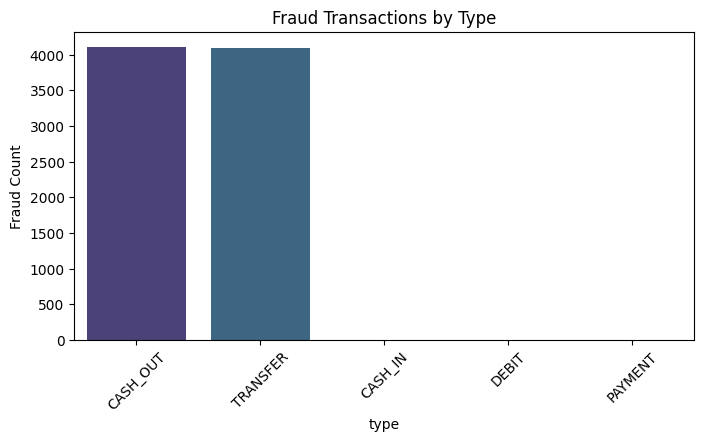

In [82]:
plt.figure(figsize=(8, 4))
sns.barplot(x=fraud_by_type.index, y=fraud_by_type.values, palette="viridis")
plt.xticks(rotation=45)
plt.ylabel("Fraud Count")
plt.title("Fraud Transactions by Type")
plt.show();

### Checking balance inconsistencies

In [83]:
# Balance Consistency Check (Difference should match amount)
df["balance_check"] = df["oldbalanceOrg"] - df["amount"] - df["newbalanceOrig"]
inconsistent_balance = df[abs(df["balance_check"])>1]
inconsistent_balance.sample(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balance_check
5250175,371,CASH_OUT,203917.85,C1423857509,0.00,0.00,C1433381470,629109.95,833027.79,0,0,-203917.85
1713823,160,CASH_OUT,378341.99,C668060920,14133.00,0.00,C1560836207,1728704.45,2107046.44,0,0,-364208.99
4146333,303,CASH_OUT,138853.64,C1301864549,0.00,0.00,C623258347,151063.48,289917.11,0,0,-138853.64
3096263,235,PAYMENT,8897.24,C1388516397,2169.00,0.00,M794249652,0.00,0.00,0,0,-6728.24
5652469,396,CASH_IN,237928.39,C1157668625,21027796.79,21265725.18,C431824984,740880.80,502952.41,0,0,-475856.78
2981603,231,CASH_OUT,299447.92,C1556981307,27148.00,0.00,C1949753976,190310.78,489758.70,0,0,-272299.92
2943792,230,CASH_IN,226358.33,C731081989,13657.00,240015.33,C1684527338,226779.29,420.95,0,0,-452716.66
909178,43,TRANSFER,443335.13,C1653343624,539.00,0.00,C307667369,1080324.74,1138482.92,0,0,-442796.13
1114108,130,CASH_IN,163896.95,C1821403033,35915.00,199811.95,C10582364,197891.63,33994.68,0,0,-327793.90
3859311,283,TRANSFER,98322.99,C1428548119,0.00,0.00,C567122362,369199.07,467522.06,0,0,-98322.99


In [84]:
inconsistent_balance.shape

(5000784, 12)

##### We see a large number balances are negative but are not fraud. This can be due to availability of overdraft facility

### Checking for high value transactions as compared to the senders' balance

In [85]:
df["high_amount_flag"] = df["amount"] > (df["oldbalanceOrg"] * 0.9)  # More than 90% of balance
high_amount_fraud = df.groupby("high_amount_flag")["isFraud"].agg(total_transactions="count",fraud_transactions="sum").reset_index()
high_amount_fraud

,high_amount_flag,total_transactions,fraud_transactions
0,False,2224250,152
1,True,4138370,8061


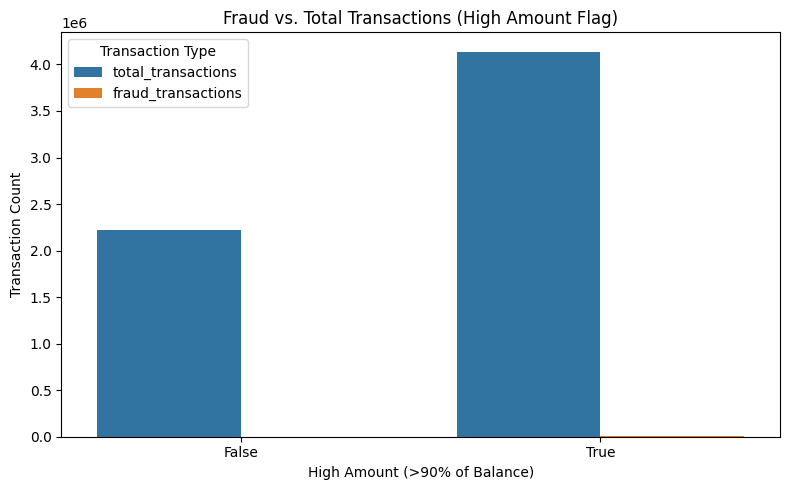

In [86]:
# Plotting
plt.figure(figsize=(8, 5))
high_amount_fraud_melted = high_amount_fraud.melt(id_vars='high_amount_flag',value_vars=['total_transactions', 'fraud_transactions'],var_name='Type', value_name='Count')

sns.barplot(data=high_amount_fraud_melted, x='high_amount_flag', y='Count', hue='Type')

plt.title("Fraud vs. Total Transactions (High Amount Flag)")
plt.xlabel("High Amount (>90% of Balance)")
plt.ylabel("Transaction Count")
plt.xticks([0, 1], ['False', 'True'])
plt.legend(title='Transaction Type')
plt.tight_layout()
plt.show()

In [87]:
high_amount_fraud_melted

,high_amount_flag,Type,Count
0,False,total_transactions,2224250
1,True,total_transactions,4138370
2,False,fraud_transactions,152
3,True,fraud_transactions,8061


In [88]:
high_amount_fraud.iloc[1,2]/high_amount_fraud.iloc[1,1]*100

0.19478683636310914

Therefore out of all high amount transactions only 0.19% of them are fraud. Therefore it is not a useful feature

### Checking for consecutive transactions involving same amount

In [89]:
# column to track previous amount
df["prev_amount"] = df["amount"].shift(1)

# another column to track next amount
df["next_amount"] = df["amount"].shift(-1)
# Set flag to True if the amount is the same in consecutive rows (both forward and backward check)
df["same_amount_flag"] = (df["amount"] == df["prev_amount"]) | (df["amount"] == df["next_amount"])

In [90]:
same_amount_fraud=df.groupby("same_amount_flag")["isFraud"].agg(total_transactions="count",fraud_transactions="sum").reset_index()
same_amount_fraud

,same_amount_flag,total_transactions,fraud_transactions
0,False,6352714,60
1,True,9906,8153


In [91]:
same_amount_fraud.iloc[1,2]/same_amount_fraud.iloc[1,1]*100

82.30365435089844

This means around 82% of the total transactions having same amount transacted consecutively is fraud. Therefor same_amount flag is a new engineered feature

In [92]:
same_amt_filtered=df[df["same_amount_flag"]==True]

In [93]:
same_amt_filtered.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balance_check,high_amount_flag,prev_amount,next_amount,same_amount_flag
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0,0.0,True,1864.28,181.00,True
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0,0.0,True,181.00,11668.14,True
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0,0.0,True,3823.08,2806.00,True
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0,0.0,True,2806.00,6737.20,True
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0,0.0,True,6969.67,20128.00,True


### Checking for transaction pattern type i.e. for same amount transacted consecutively, whether there is always a transfer followed by cash out

In [94]:
# shifting columns for next and previous transaction type
df["next_type"] = df["type"].shift(-1)
df["prev_type"] = df["type"].shift(1)
#checking for transfer-cashout block where same amount has been transacted
df['transfer_cashout_block']=(df["type"] == "TRANSFER") & (df["next_type"] == "CASH_OUT") & (df["same_amount_flag"] ==True)|(df["type"] == "CASH_OUT") & (df["prev_type"] == "TRANSFER") & (df["same_amount_flag"] ==True)

In [95]:
transfer_cashout_pattern = df.groupby("transfer_cashout_block")["isFraud"].agg(total_transactions="count",fraud_transactions="sum").reset_index()
transfer_cashout_pattern

,transfer_cashout_block,total_transactions,fraud_transactions
0,False,6354467,60
1,True,8153,8153


This means all the transactions following this transfer-cashout pattern are fraud transactions!
Therefore 'transfer_cashout_block' becomes a useful engineered feature

### Checking total number of transactions per user

In [96]:
# Counting total transactions per user
df["transaction_count"] = df.groupby("nameOrig")["nameOrig"].transform("count")

# Checking how fraud cases are distributed across transaction frequency
fraud_by_frequency = df.groupby("transaction_count")["isFraud"].count()

In [97]:
fraud_by_frequency

transaction_count
1    6344009
2      18566
3         45
Name: isFraud, dtype: int64

In [98]:
# Grouping by transaction count and calculate total transactions and frauds
fraud_stats = df.groupby("transaction_count")["isFraud"].agg(total_transactions="count",fraud_transactions="sum").reset_index()
fraud_stats

,transaction_count,total_transactions,fraud_transactions
0,1,6344009,8185
1,2,18566,28
2,3,45,0


There is no significant pattern found using transaction count sorted by origin's name

### Dropping features that are not useful

In [99]:
df.sample(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balance_check,high_amount_flag,prev_amount,next_amount,same_amount_flag,next_type,prev_type,transfer_cashout_block,transaction_count
2228944,186,CASH_IN,83246.30,C1638482299,21924131.08,22007377.39,C1200034815,204915.38,121669.07,0,0,-166492.61,False,284159.86,55339.53,False,CASH_IN,CASH_IN,False,1
447609,19,CASH_IN,57507.97,C367173931,3222719.63,3280227.60,C457781839,360693.08,303185.11,0,0,-115015.94,False,341404.92,134453.84,False,CASH_IN,CASH_IN,False,1
812682,40,PAYMENT,9078.85,C1436787585,0.00,0.00,M1715524471,0.00,0.00,0,0,-9078.85,True,31115.87,611037.82,False,TRANSFER,PAYMENT,False,1
1250761,134,PAYMENT,22621.68,C1943945931,0.00,0.00,M1831238982,0.00,0.00,0,0,-22621.68,True,31106.19,4804.56,False,PAYMENT,CASH_OUT,False,1
4141056,303,CASH_OUT,94883.28,C776670484,20150.00,0.00,C703107589,816779.02,911662.30,0,0,-74733.28,True,22400.99,217787.81,False,CASH_IN,PAYMENT,False,1


In [100]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'balance_check', 'high_amount_flag', 'prev_amount',
       'next_amount', 'same_amount_flag', 'next_type', 'prev_type',
       'transfer_cashout_block', 'transaction_count'],
      dtype='object')

In [162]:
df_encoded= pd.get_dummies(df, columns=["type"], drop_first=True)
df_encoded.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,...,next_amount,same_amount_flag,next_type,prev_type,transfer_cashout_block,transaction_count,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,...,1864.28,False,PAYMENT,None,False,1,False,False,True,False
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,...,181.00,False,TRANSFER,PAYMENT,False,1,False,False,True,False
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,...,181.00,True,CASH_OUT,PAYMENT,True,1,False,False,False,True
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,...,11668.14,True,PAYMENT,TRANSFER,True,1,True,False,False,False
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,...,7817.71,False,PAYMENT,CASH_OUT,False,1,False,False,True,False


In [101]:
data=df.drop(columns=['nameOrig','oldbalanceOrg','newbalanceOrig','nameDest', 'oldbalanceDest', 'newbalanceDest','balance_check','high_amount_flag',
                      'prev_amount','next_amount','next_type', 'prev_type','transaction_count'])
data["same_amount_flag"] = data["same_amount_flag"].astype(int)
data["transfer_cashout_block"] = data["transfer_cashout_block"].astype(int)

In [102]:
data.head()

,step,type,amount,isFraud,isFlaggedFraud,same_amount_flag,transfer_cashout_block
0,1,PAYMENT,9839.64,0,0,0,0
1,1,PAYMENT,1864.28,0,0,0,0
2,1,TRANSFER,181.00,1,0,1,1
3,1,CASH_OUT,181.00,1,0,1,1
4,1,PAYMENT,11668.14,0,0,0,0


### One Hot Encoding

In [103]:
data= pd.get_dummies(data, columns=["type"], drop_first=True)
data.head()

,step,amount,isFraud,isFlaggedFraud,same_amount_flag,transfer_cashout_block,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,0,0,0,0,False,False,True,False
1,1,1864.28,0,0,0,0,False,False,True,False
2,1,181.00,1,0,1,1,False,False,False,True
3,1,181.00,1,0,1,1,True,False,False,False
4,1,11668.14,0,0,0,0,False,False,True,False


### Correlation Matrix

In [104]:
corr = data.corr()
corr

,step,amount,isFraud,isFlaggedFraud,same_amount_flag,transfer_cashout_block,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
step,1.000000,0.022373,0.031578,0.003277,0.031856,0.031621,-0.012918,0.002869,0.004926,0.006925
amount,0.022373,1.000000,0.076688,0.012295,0.183029,0.076619,-0.004376,-0.023379,-0.197444,0.365896
isFraud,0.031578,0.076688,1.000000,0.044109,0.903763,0.996336,0.011256,-0.002911,-0.025697,0.053869
isFlaggedFraud,0.003277,0.012295,0.044109,1.000000,0.007479,0.008255,-0.001168,-0.000128,-0.001133,0.005245
same_amount_flag,0.031856,0.183029,0.903763,0.007479,1.000000,0.907088,0.004937,-0.003197,-0.028225,0.071939
transfer_cashout_block,0.031621,0.076619,0.996336,0.008255,0.907088,1.000000,0.011114,-0.002900,-0.025603,0.053845
type_CASH_OUT,-0.012918,-0.004376,0.011256,-0.001168,0.004937,0.011114,1.000000,-0.059625,-0.526422,-0.222672
type_DEBIT,0.002869,-0.023379,-0.002911,-0.000128,-0.003197,-0.002900,-0.059625,1.000000,-0.057868,-0.024478
type_PAYMENT,0.004926,-0.197444,-0.025697,-0.001133,-0.028225,-0.025603,-0.526422,-0.057868,1.000000,-0.216110
type_TRANSFER,0.006925,0.365896,0.053869,0.005245,0.071939,0.053845,-0.222672,-0.024478,-0.216110,1.000000


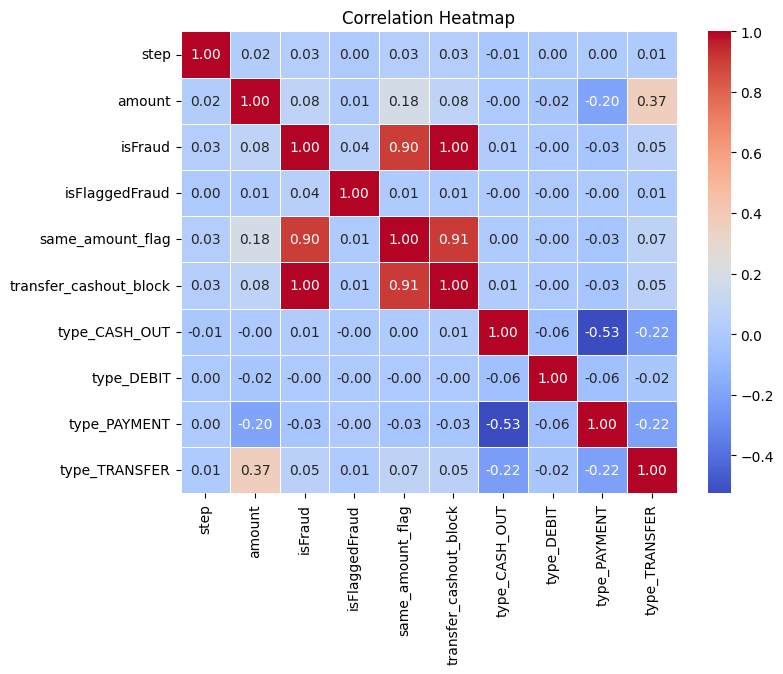

In [105]:
# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

#### It is clearly visible that fraud transactions are highly correlated with the two engineered features i.e. 'same_amount_flag' and 'transfer_cashout_block'. But the two features are also correlated among themselves indicating Multicollinearity. This is natural as the latter feature is made using the former. We will study its consequences as we remove one of them

## Modelling and Evaluation


### Splitting Train Test Data

In [106]:
# Defining features and target
X = data.drop("isFraud", axis=1)
y = data["isFraud"]

In [107]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### Logistic Regression

In [108]:
# Using class_weight='balanced' to handle imbalance
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

#### Evaluation

In [109]:
y_pred = lr_model.predict(X_test)
cm=confusion_matrix(y_test, y_pred)
cm

array([[1270432,     449],
       [      7,    1636]], dtype=int64)

In [110]:
cm_df = pd.DataFrame(
    cm,
    index=["Actual: Not Fraud", "Actual: Fraud"],
    columns=["Predicted: Not Fraud", "Predicted: Fraud"]
)
cm_df

,Predicted: Not Fraud,Predicted: Fraud
Actual: Not Fraud,1270432,449
Actual: Fraud,7,1636


In [111]:
[[TN, FP],  
 [FN, TP]] = [[cm[0,0], cm[0,1]],  
              [cm[1,0], cm[1,1]]]
# Metrics
accuracy  = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall    = TP / (TP + FN)
f1_score  = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1_score:.4f}")

Accuracy : 0.9996
Precision: 0.7847
Recall   : 0.9957
F1 Score : 0.8777


In the current business problem, False Negatives are very costly, i.e. detecting a fraud transaction as a non fraud transaction is more harmful than the no. of False Positives. This makes Recall an important metric. Here the Recall is 99.57% which is a good result. The F1 score is 87.8%

#### Model Improvement by dropping more unimportant features

In [112]:
data.head()

,step,amount,isFraud,isFlaggedFraud,same_amount_flag,transfer_cashout_block,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,0,0,0,0,False,False,True,False
1,1,1864.28,0,0,0,0,False,False,True,False
2,1,181.00,1,0,1,1,False,False,False,True
3,1,181.00,1,0,1,1,True,False,False,False
4,1,11668.14,0,0,0,0,False,False,True,False


In [140]:
data_improv=data.drop(columns=['amount','isFlaggedFraud','type_CASH_OUT','type_DEBIT','type_PAYMENT','type_TRANSFER','step'])

In [141]:
data_improv.head()

,isFraud,same_amount_flag,transfer_cashout_block
0,0,0,0
1,0,0,0
2,1,1,1
3,1,1,1
4,0,0,0


In [142]:
# Defining features and target
X = data_improv.drop("isFraud", axis=1)
y = data_improv["isFraud"]

In [144]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [145]:
# Using class_weight='balanced' to handle imbalance
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

#### Evaluation of Logistic Regression Model

In [146]:
y_pred = lr_model.predict(X_test)
cm=confusion_matrix(y_test, y_pred)
cm

array([[1270528,     353],
       [      7,    1636]], dtype=int64)

In [147]:
cm_df = pd.DataFrame(
    cm,
    index=["Actual: Not Fraud", "Actual: Fraud"],
    columns=["Predicted: Not Fraud", "Predicted: Fraud"]
)
cm_df

,Predicted: Not Fraud,Predicted: Fraud
Actual: Not Fraud,1270528,353
Actual: Fraud,7,1636


In [148]:
[[TN, FP],  
 [FN, TP]] = [[cm[0,0], cm[0,1]],  
              [cm[1,0], cm[1,1]]]
# Metrics
accuracy  = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall    = TP / (TP + FN)
f1_score_lr  = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1_score_lr:.4f}")

Accuracy : 0.9997
Precision: 0.8225
Recall   : 0.9957
F1 Score : 0.9009


We had improved the precision and thus, the F1 score from 87.8 to 90.1% using just the important features! We further try to improve this model by removing one of the redundant features

In [154]:
data_improv.drop(columns=['same_amount_flag'],inplace=True)
# Defining features and target
X = data_improv.drop("isFraud", axis=1)
y = data_improv["isFraud"]

In [155]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [156]:
# Using class_weight='balanced' to handle imbalance
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

#### Evaluation of Logistic Regression Model

In [157]:
y_pred = lr_model.predict(X_test)
cm=confusion_matrix(y_test, y_pred)
cm

array([[1270881,       0],
       [      7,    1636]], dtype=int64)

In [158]:
cm_df = pd.DataFrame(
    cm,
    index=["Actual: Not Fraud", "Actual: Fraud"],
    columns=["Predicted: Not Fraud", "Predicted: Fraud"]
)
cm_df

,Predicted: Not Fraud,Predicted: Fraud
Actual: Not Fraud,1270881,0
Actual: Fraud,7,1636


In [160]:
[[TN, FP],  
 [FN, TP]] = [[cm[0,0], cm[0,1]],  
              [cm[1,0], cm[1,1]]]
# Metrics
accuracy  = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall    = TP / (TP + FN)
f1_score_lr_improved  = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1_score_lr_improved:.4f}")

Accuracy : 1.0000
Precision: 1.0000
Recall   : 0.9957
F1 Score : 0.9979


##### The model does better when one of the multicollinear features get removed. The F1 score improves by almost 9%

### Random Forest

In [166]:
# Initializing Random Forest
rf_model = RandomForestClassifier(
n_estimators=100, # Number of trees
max_depth=None, # Allow trees to grow fully
max_features="sqrt", # Number of features per split
random_state=42
)

# Fit on training data
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

#### Evaluation of Random Forest Model

In [167]:
# Evaluating
#Confusion Matrix
cm=confusion_matrix(y_test, y_pred_rf)
cm

array([[1270881,       0],
       [      7,    1636]], dtype=int64)

In [168]:
cm_df = pd.DataFrame(
    cm,
    index=["Actual: Not Fraud", "Actual: Fraud"],
    columns=["Predicted: Not Fraud", "Predicted: Fraud"]
)
cm_df

,Predicted: Not Fraud,Predicted: Fraud
Actual: Not Fraud,1270881,0
Actual: Fraud,7,1636


In [169]:
[[TN, FP],  
 [FN, TP]] = [[cm[0,0], cm[0,1]],  
              [cm[1,0], cm[1,1]]]
# Metrics
accuracy  = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall    = TP / (TP + FN)
f1_score_rf  = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1_score_rf:.4f}")

Accuracy : 1.0000
Precision: 1.0000
Recall   : 0.9957
F1 Score : 0.9979


The models' metrics remain the same.

C:\Users\Suhaditya Chakrabort\AppData\Local\Temp\ipykernel_23156\3437569736.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importances, palette="viridis")


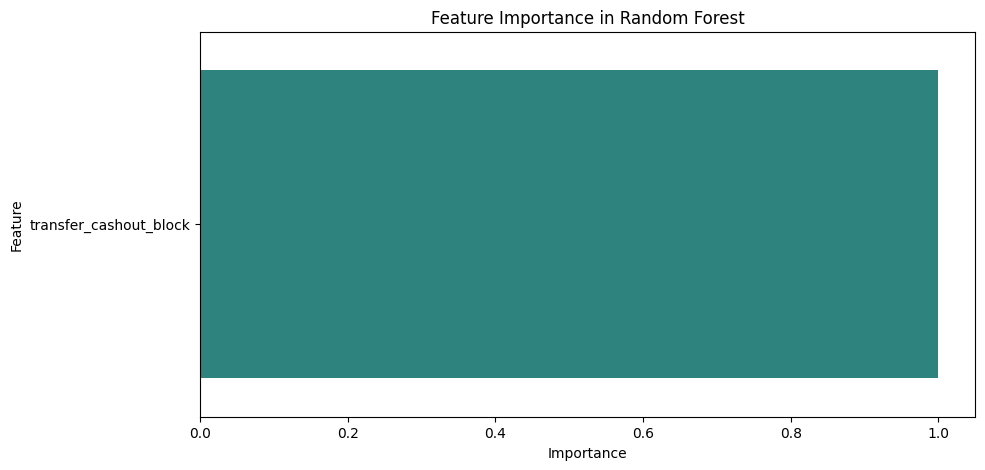

In [170]:
# Getting feature importance scores
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
})

# Sorting features by importance
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=feature_importances, palette="viridis")
plt.title("Feature Importance in Random Forest")
plt.show()

### XGBoost

In [171]:
# Initializing the XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # Handle class imbalance
    random_state=42,
    n_jobs=-1
)

# Fitting the model
xgb_model.fit(X_train, y_train)

# Predicting
y_pred_xgb = xgb_model.predict(X_test)


c:\Users\Suhaditya Chakrabort\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:01:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


#### Evaluation of XG Boost Model

In [172]:
# Evaluating
#Confusion Matrix
cm=confusion_matrix(y_test, y_pred_rf)
cm

array([[1270881,       0],
       [      7,    1636]], dtype=int64)

In [173]:
cm_df = pd.DataFrame(
    cm,
    index=["Actual: Not Fraud", "Actual: Fraud"],
    columns=["Predicted: Not Fraud", "Predicted: Fraud"]
)
cm_df

,Predicted: Not Fraud,Predicted: Fraud
Actual: Not Fraud,1270881,0
Actual: Fraud,7,1636


In [129]:
[[TN, FP],  
 [FN, TP]] = [[cm[0,0], cm[0,1]],  
              [cm[1,0], cm[1,1]]]
# Metrics
accuracy  = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall    = TP / (TP + FN)
f1_score_xgb  = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1_score_xgb:.4f}")

Accuracy : 1.0000
Precision: 1.0000
Recall   : 0.9957
F1 Score : 0.9979


##### The metrics' value doesn't change even after using XG Boost. The Final Recall value = 0.9957 which means that our model can detect a fraud 99.57% of the times an actual fraud happens. Final F1 score: 0.9979

##### Thus we conclude our modelling part here.

## Model Comparison

C:\Users\Suhaditya Chakrabort\AppData\Local\Temp\ipykernel_23156\3031851120.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='F1 Score', data=f1_scores,palette='pastel')


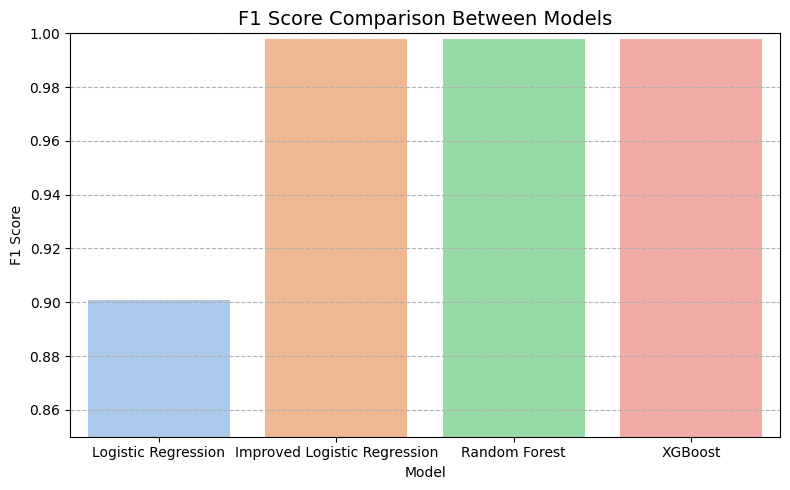

In [174]:
f1_scores = pd.DataFrame({
    'Model': ['Logistic Regression','Improved Logistic Regression', 'Random Forest', 'XGBoost'],
    'F1 Score': [f1_score_lr,f1_score_lr_improved, f1_score_rf, f1_score_xgb]
})

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='F1 Score', data=f1_scores,palette='pastel')
plt.title('F1 Score Comparison Between Models', fontsize=14)
plt.ylabel('F1 Score')
plt.ylim(0.85, 1.0)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show();

##### This is expected as after careful feature engineering, the no. of significant features got reduced to 1. The RF and XGB does not have a remarkable impact as we are working with just 1 feature. Out of all the models, I would definitely choose the Logistic Regression one as it has the same performance while retaining interpretability of the model. Also, the treshold can be further fine tuned as per the company's requirement.

## Summary

### Data cleaning including missing values, outliers and multicollinearity
Data Cleaning Highlights:
Missing Values: Checked using .isnull().sum() — no missing values found.
Outliers: Retained in the dataset, as frauds are inherently outliers. Instead, captured suspicious behavior using flags like:
high_amount_flag (amount > 90% of balance),same_amount_flag (consecutive same amounts),and transfer_cashout_block (fraud-like sequences).

Multicollinearity:

Instead, redundant balance-related columns were dropped after creating more meaningful features (balance_check, high_amount_flag).
Manual inspection and correlation heatmaps helped in selecting non-redundant features.

### Describe your fraud detection model in elaboration

Models Tried:
Logistic Regression: Baseline, interpretable.
Random Forest: High performance, feature importance insights.
XGBoost: Best performance, robust to imbalance.

Imbalance Handling:
Used class_weight='balanced' for tree models.
Sampling for train and test sets stratified

Evaluation Metrics:
Confusion Matrix
Accuracy, Precision, Recall, F1 Score


### How did you select variables to be included in the model?

Selection Strategy:
Removed identification variables (nameOrig, nameDest, etc.).

One-hot encoded the type variable.

Engineered fraud-relevant features based on domain intuition:same_amount_flag, transfer_cashout_block, high_amount_flag

Removed balance fields after feature engineering.

Ensured low correlation between remaining features.

### Demonstrate the performance of the model by using best set of tools
Model Performance (Logistic Regression):

Accuracy: 1.0000

Precision: 1.0000

Recall: 0.9957

F1 Score: 0.9979

Tools Used:

confusion_matrix, recall, F1 score 

Plotted F1 Score comparison across models

###  What are the key factors that predict fraudulent customer?
transfer_cashout_block: All frauds occurred in this transaction pattern.

same_amount_flag: Indicates automation or repeated fraud attempts.

type: Only TRANSFER and CASH_OUT are linked to fraud.

### Do these factors make sense? If yes, How? If not, How not?
Yes, they align well with real-world fraud behaviors:

Fraudsters often chain transfers and cash outs.

They frequently use identical amounts for consistency or bot automation.

Large withdrawals are often attempted in one go.

The pattern-based features captured hidden fraud indicators effectively.

### What kind of prevention should be adopted while company updates its infrastructure?
Real-time flagging of transfer → cash out patterns.

Alert on repeated transaction amounts.

Add strong verification for high-value transactions.

Deploy adaptive ML models retrained regularly on new data.

Build rate-limiters to block rapid transaction sequences.

### Assuming these actions have been implemented, how would you determine if they work?
Compare fraud metrics (false negatives, recall) before and after implementation.

Use A/B testing on transaction pipelines.

Monitor fraud trend over time.

Track customer disputes and complaint rates.

Run periodic model revalidation to measure detection quality.